# Overview

This notebook presents several classifiers aiming to predict startups success (aquired or failed, no IPO data in the imput dataset) based on the avaliable data.
 For the input data analysis, please view EDA notebood in the same repository.
 The dataset can be found here: https://www.kaggle.com/datasets/manishkc06/startup-success-prediction/data

 # Take code from git

In [ ]:
!git clone https://github.com/MayaVB/Applied_DS_Project.git

In [ ]:
!ls Applied_DS_Project

In [ ]:
!ls Applied_DS_Project/src

# Install requirements

In [ ]:
!pip install -r Applied_DS_Project/requirements.txt

In [ ]:
# consider for future features
# %pip install yfinance
# %pip install tweepy
# %pip install wbdata pandas
# %pip install xgboost

# Imports

In [1]:
# set working directory:
# %cd Applied_DS_Project/src

# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from eval import plot_feature_importances, plot_auc_roc_curve, perform_cross_validation
from getdata import add_nasdaq_annual_changes, add_economic_indicators
from models import train_xgb_model, train_rf_model, train_svm_model, train_decision_tree_model
from models import train_rfv2_model
from models import evaluate_model, predict_model
from printstatistics import print_correlations_Spearman_and_Pearson
from preprocess import load_data, preprocess_data

from scipy.stats import mode
import numpy as np

In [2]:
def set_seed(random_seed):
    np.random.seed(random_seed)  # Set seed for NumPy operations to ensure reproducibility
    #random.seed(random_seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1' # Ensure deterministic operations

# Load Data

In [3]:
df = load_data('../data/startup_data.csv')

# Convert the date column to datetime
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'])

# Extract year, month, and day into separate columns
df['first_funding_at_year'] = df['first_funding_at'].dt.year
df['first_funding_at_month'] = df['first_funding_at'].dt.month
df['first_funding_at_day'] = df['first_funding_at'].dt.day


# Convert the date column to datetime
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'])

# Extract year, month, and day into separate columns
df['first_funding_at_year'] = df['last_funding_at'].dt.year
df['first_funding_at_month'] = df['last_funding_at'].dt.month
df['first_funding_at_day'] = df['last_funding_at'].dt.day


df = df.drop(columns=['first_funding_at', 'last_funding_at', 'state_code.1'])
#in this dataset state_code is safe to drop as the vast majority of the starttups in this dataset are in locations with high VC activity

In [ ]:
# # Create label
# df['status_code'] = df['status'].map({'acquired': 1, 'closed': 0})

# print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

# print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

# df.drop(columns=['status_code'])

# Preprocess Data

In [4]:
# Add economic indicators
df = add_nasdaq_annual_changes(df)
indicator_code = 'NY.GDP.MKTP.KD.ZG'
df = add_economic_indicators(df, indicator_code)
indicator_code = 'SL.UEM.TOTL.ZS'
df = add_economic_indicators(df, indicator_code)

# Preprocess the data
X, y = preprocess_data(df, useKNNImputer=True)

random_state = 42
set_seed(random_state)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

[*********************100%%**********************]  1 of 1 completed
/home/mayavb/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X.head()
# X['is_web']


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# X['is_web']


In [5]:
# Calculate the ratio of negative class to positive class
train_ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
print(train_ratio)
test_ratio = float(y_test.value_counts()[0]) / y_test.value_counts()[1]
test_ratio

0.5471698113207547


0.5416666666666666

# Train predict and evaluate classifiers

## Stratified sampling for cross validation

In [6]:
def get_ratio(y_train_cv):
  return float(y_train_cv.value_counts()[0]) / y_train_cv.value_counts()[1]

def cross_validation_generator(X, y, fold):
  skf = StratifiedKFold(n_splits=fold, random_state=random_state, shuffle=True)
  return skf.split(X, y)

## XG Boost

### cross-validation with stratified sampling

In [ ]:
# fold = 5
# #np.zeros(fold)
# for i, (train_index, test_index) in enumerate(cross_validation_generator(X, y, fold)):
#   print(f"Fold {i}, ratio {round(get_ratio(y[train_index]), 2)}:")
#   xgb_clf = train_xgb_model(X.iloc[train_index] ,  y[train_index])
#   xgb_pred, xgb_prob = predict_model(xgb_clf, X.iloc[test_index])
#   evaluate_model(y[test_index], xgb_pred, xgb_prob, threshold=0.5)

### single split

In [ ]:
xgb_clf = train_xgb_model(X_train, y_train)
xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
evaluate_model(y_test, xgb_pred, xgb_prob, threshold=0.5)
cv_results_xgb = perform_cross_validation(xgb_clf, X_train, y_train, n_splits=5, random_state=random_state)

plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, xgb_prob, model_name='XG-Boost')

## Random Forest Ver2

In [ ]:
rfv2_clf = train_rfv2_model(X_train, y_train)
rfv2_pred, rfv2_prob = predict_model(rfv2_clf, X_test)
evaluate_model(y_test, rfv2_pred, rfv2_prob)
cv_results_rfv2 = perform_cross_validation(rfv2_clf, X_train, y_train, n_splits=5, random_state=random_state)

plot_feature_importances(rfv2_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, rfv2_prob, model_name='randomForestV2')

## Fandom Forest

In [ ]:
rf_clf = train_rf_model(X_train, y_train)
rf_pred, rf_prob = predict_model(rf_clf, X_test)
evaluate_model(y_test, rf_pred, rf_prob)
cv_results_rf = perform_cross_validation(rf_clf, X_train, y_train, n_splits=5, random_state=random_state)

plot_feature_importances(rf_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, rf_prob, model_name='randomForest')

## Decision tree

In [ ]:
dt_clf = train_decision_tree_model(X_train, y_train)
dt_pred, dt_prob = predict_model(dt_clf, X_test)
evaluate_model(y_test, dt_pred, dt_prob)
cv_results_dt = perform_cross_validation(dt_clf, X_train, y_train, n_splits=5, random_state=42)

plot_auc_roc_curve(y_test, dt_prob, model_name='Decision Tree')

## SVM

In [ ]:
svm_clf = train_svm_model(X_train, y_train)
svm_pred, svm_prob = predict_model(svm_clf, X_test)
evaluate_model(y_test, svm_pred, svm_prob)
cv_results_SVM = perform_cross_validation(svm_clf, X_train, y_train, n_splits=5, random_state=42)

plot_auc_roc_curve(y_test, svm_prob, model_name='SVM')

## Compare

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Confusion Matrix (Test):
[[44 21]
 [23 97]]


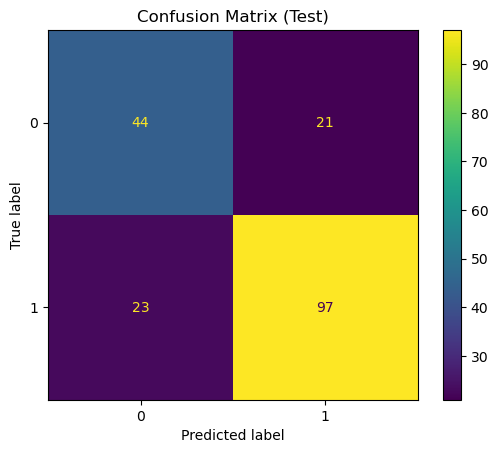

Precision (Test): 0.8220338983050848
Recall (Test): 0.8083333333333333


KeyError: 'Accuracy'

In [7]:
# # Train, predict and evaluate models
# models = {
#     'Random Forest v2': train_rfv2_model,
#     'XGBoost': train_xgb_model,
#     'Random Forest': train_rf_model,
#     'SVM': train_svm_model
# }

# metrics = {name: {} for name in models.keys()}

# for name, train_func in models.items():
#     model = train_func(X_train, y_train)
#     pred, prob = predict_model(model, X_test)
#     metrics[name] = evaluate_model(y_test, pred, prob, threshold=0.7)

#     # Extract metrics
#     metric_names = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall']
    
#     # Create lists to store the values
#     values = {metric: [] for metric in metric_names}
#     colors = {
#         'Random Forest v2': 'blue',
#         'XGBoost': 'green',
#         'Random Forest': 'red',
#         'SVM': 'purple'
#     }
    
#     for model_name, model_metrics in metrics.items():
#         for metric in metric_names:
#             values[metric].append(model_metrics[metric])
    
#     # Plotting the metrics
#     bar_width = 0.2
#     index = np.arange(len(metric_names))
    
#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     for i, model_name in enumerate(metrics.keys()):
#         bars = ax.bar(index + i * bar_width, values[metric_names[0]], bar_width, label=model_name, color=colors[model_name])
    
#     ax.set_xlabel('Metrics')
#     ax.set_ylabel('Scores')
#     ax.set_title('Performance Comparison of Algorithms')
#     ax.set_xticks(index + bar_width * (len(metrics) / 2 - 0.5))
#     ax.set_xticklabels(metric_names)
#     ax.legend()
    
#     plt.tight_layout()
#     plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/mayavb/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:06:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix (Test):
[[44 21]
 [23 97]]


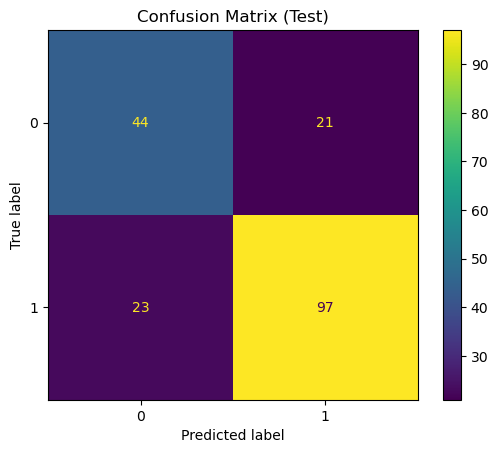

Precision (Test): 0.8220338983050848
Recall (Test): 0.8083333333333333
Confusion Matrix (Test):
[[ 43  22]
 [ 18 102]]


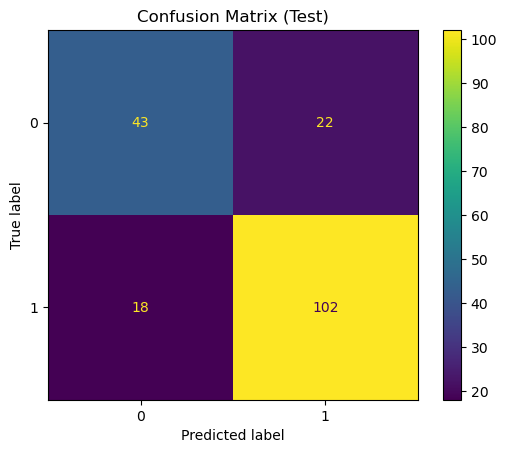

Precision (Test): 0.8225806451612904
Recall (Test): 0.85
Confusion Matrix (Test):
[[ 44  21]
 [ 18 102]]


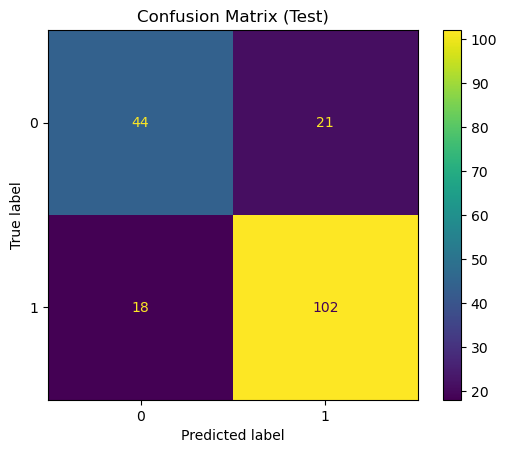

Precision (Test): 0.8292682926829268
Recall (Test): 0.85
Confusion Matrix (Test):
[[ 36  29]
 [ 14 106]]


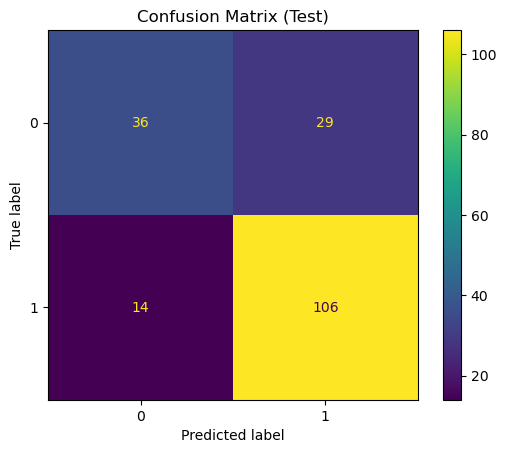

Precision (Test): 0.7851851851851852
Recall (Test): 0.8833333333333333
Confusion Matrix (Test):
[[40 25]
 [32 88]]


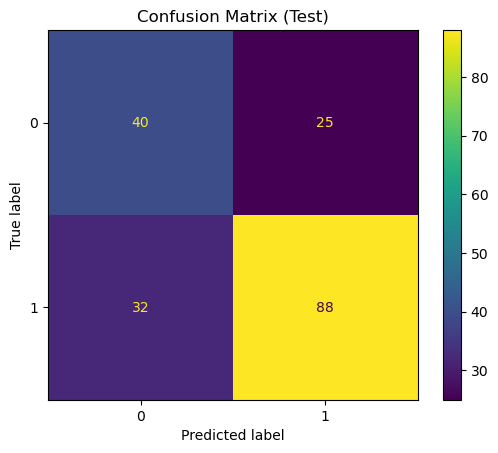

Precision (Test): 0.7787610619469026
Recall (Test): 0.7333333333333333


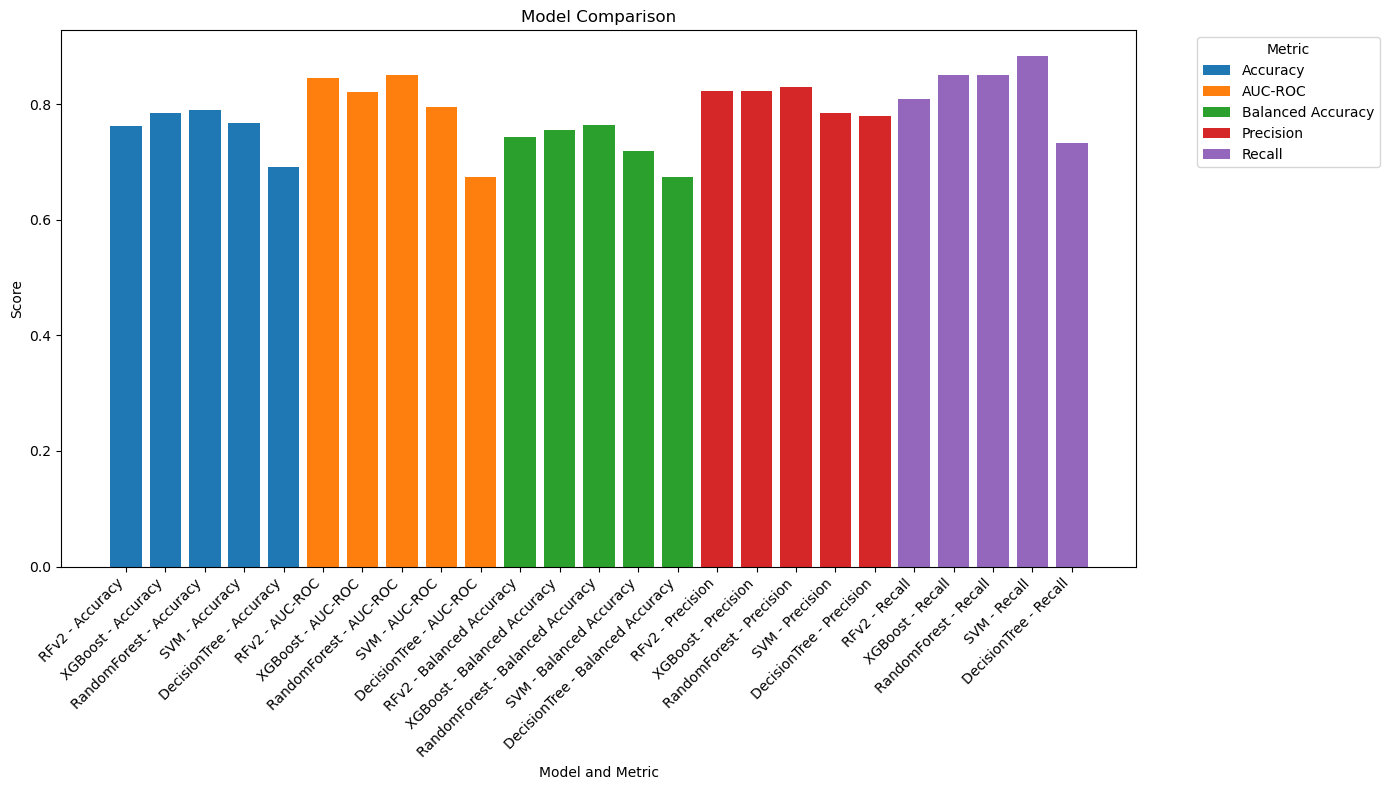

In [8]:
metrics = {}

models = {
    'RFv2': train_rfv2_model(X_train, y_train),
    'XGBoost': train_xgb_model(X_train, y_train),
    'RandomForest': train_rf_model(X_train, y_train),
    'SVM': train_svm_model(X_train, y_train),
    'DecisionTree': train_decision_tree_model(X_train, y_train)
}

for name, model in models.items():
    y_pred, y_prob = predict_model(model, X_test)
    metrics[name] = evaluate_model(y_test, y_pred, y_prob, threshold=0.7)

colors = {
    'Random Forest v2': 'blue',
    'XGBoost': 'green',
    'Random Forest': 'red',
    'SVM': 'purple'
}

# Convert metrics to DataFrame for plotting
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_df.columns = ['Model', 'Metric', 'Score']

plt.figure(figsize=(14, 8))
for metric in metrics_df['Metric'].unique():
    subset = metrics_df[metrics_df['Metric'] == metric]
    plt.bar(subset['Model'] + ' - ' + metric, subset['Score'], label=metric)

plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Model and Metric')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Ensemble classifiers

## Ensemble all

In [ ]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, rf_pred, svm_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + rf_prob + svm_prob) / 4

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Ensemble with SVM

In [ ]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, svm_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + svm_prob) / 3

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Ensemble without SVM

In [ ]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, rf_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + rf_prob) / 3

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

# Analyse results

## Combine with the original features

In [ ]:
import pandas as pd

# Create DataFrame with all features, y_test, and predictions
result_df = pd.DataFrame(X_test, columns=X.columns)
result_df['Actual'] = y_test.values
'''
result_df['Predicted_xgb'] = xgb_pred
result_df['Probability_xgb'] = xgb_prob
result_df['Predicted_rfv2'] = rfv2_pred
result_df['Probability_rfv2'] = rfv2_prob
result_df['Predicted_rf'] = rf_pred
result_df['Probability_rf'] = rf_prob
result_df['Predicted_svm'] = svm_pred
result_df['Probability_svm'] = svm_prob
'''
result_df['Predicted_ensemble'] = ensemble_pred
result_df['Probability_ensemble'] = ensemble_prob

# Display the DataFrame
result_df.head()

## try - drafts

In [ ]:
df1 = load_data('../data/startup_data.csv')

In [ ]:
plt.figure(figsize=(14, 5))

# Plot distribution for relationships on the left
plt.subplot(1, 2, 1)
sns.kdeplot(correct_original_df['relationships'], shade=True, label='Correct', color='g')
sns.kdeplot(incorrect_original_df['relationships'], shade=True, label='Incorrect', color='r')
plt.title('Distribution of "relationships"')
plt.legend()

# Plot distribution for founded_at_year on the right
plt.subplot(1, 2, 2)
sns.kdeplot(correct_original_df['founded_at_year'], shade=True, label='Correct', color='g')
sns.kdeplot(incorrect_original_df['founded_at_year'], shade=True, label='Incorrect', color='r')
plt.title('Distribution of "founded_at_year"')
plt.legend()

# Add a big title to the entire figure
plt.suptitle('High effect Feature Distributions for Correct and Incorrect Predictions', fontsize=16, y=1.05)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
df1.category_code.value_counts()

In [ ]:
result_df_ok = result_df[result_df['Predicted_ensemble'] == result_df['Actual']]
result_df_fail = result_df[result_df['Predicted_ensemble'] != result_df['Actual']]

print(result_df_ok['category_code_biotech'].value_counts() / len(result_df_ok))

In [ ]:
print(result_df_ok.category_code_biotech.value_counts())

In [ ]:
result_df_fail.category_code_finance.value_counts()

In [ ]:
result_df_fail['category_code_biotech'] = result_df_fail.category_code_biotech.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_biotech'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_biotech'].value_counts() )

In [ ]:
result_df_fail['category_code_software'] = result_df_fail.category_code_software.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_software'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_software'].value_counts() )

In [ ]:
result_df_fail['is_othercategory'] = result_df_fail.is_othercategory.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['is_othercategory'].value_counts() / len(result_df_fail))
print(result_df_fail['is_othercategory'].value_counts() )

In [ ]:
result_df.is_othercategory.value_counts()